In [1]:
options(warn = -1)
library(lubridate)
library(dplyr)
library(stringr)
library(zoo)
library(ggplot2)
library('reshape2')
library('glmnet')
library(randomForest)
library(reshape2)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: Matrix

Loaded glmnet 4.1-4

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




In [2]:
df_all = read.csv("FullDataset.csv")

In [3]:
df_all[df_all == 0] <- NA

In [4]:
df_all = na.locf(df_all)
rownames(df_all) = df_all$X
drops <- c('X')
df_all = df_all[ , !(names(df_all) %in% drops)]
df = df_all[-ncol(df_all)]
head(df)

,Annual.Hash.Growth,Block.Height,Block.Interval,Block.Size,Daily.Transactions,Difficulty,Fee.Percentage,Fee.Rate,Two.Week.Hash.Growth,Hash.Rate,...,GDX.US.Equity,SHCOMP.Index,TWSE.Index,ADS_Index,Google.trends,Lumber.prices,WTI.Oil,Sentiment.Score,label,std_BTC_returns
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13/01/2015,-0.022780113,0.000419409,0.09836066,0.18778708,0.12220541,0.08195445,1.98610114,1.26923077,0.1025754,-0.002265071,...,-0.04374128,0.001853334,0.005828966,0.02299408,0.36170213,-0.005050505,-0.003907098,0.0001,-12.232393,1.948498
14/01/2015,-0.040559036,0.000374948,0.12935323,0.15985463,-0.02503643,0.08195445,-0.73362366,-0.55932203,1.1608013,-0.019787663,...,-0.01167883,-0.003976137,-0.005586126,0.02230177,0.56250000,-0.000634518,0.058531270,0.6249,-20.573837,5.131537
15/01/2015,-0.011227970,0.000427929,-0.13950073,-0.06433805,0.08916608,0.08195445,-0.25040139,-0.03846154,-0.2450274,0.016551605,...,0.05760709,0.035382538,-0.001649196,0.02164933,-0.16000000,-0.001587302,-0.043931159,0.0001,10.537035,8.309523
16/01/2015,-0.002357966,0.000445446,-0.03242321,-0.02199099,0.11829603,0.08195445,0.05269156,0.08000000,-0.1233202,0.015791939,...,0.03165736,0.012000761,-0.002924139,0.02103097,-0.16666667,-0.008267091,0.054088971,0.0001,1.299457,11.827200
17/01/2015,0.006986954,0.000409864,0.08465609,-0.05564855,-0.12462024,0.08195445,0.10648997,-0.03703704,0.1706343,0.009865780,...,0.03165736,0.012000761,-0.002924139,0.02103097,-0.18571429,-0.008267091,0.054088971,0.0001,-3.666475,12.192678
18/01/2015,-0.004395740,0.000406748,0.01788618,-0.03218582,-0.15567167,0.08195445,0.62536206,-0.03846154,0.2578415,0.002171404,...,0.03165736,0.012000761,-0.002924139,0.02103097,-0.05263158,-0.008267091,0.054088971,0.0001,3.681805,12.017553


In [5]:
train_size = floor(0.75 * nrow(df))
train_data = df[1:train_size, ]
test_data = df[train_size:nrow(df), ]

In [6]:
train_size = floor(0.75 * nrow(train_data))
train_ds = train_data[1:train_size, ]
val_ds = train_data[train_size:nrow(train_data), ]

In [7]:
summary(df)

 Annual.Hash.Growth    Block.Height       Block.Interval     
 Min.   :-0.1762711   Min.   :0.0001619   Min.   :-0.454102  
 1st Qu.:-0.0283280   1st Qu.:0.0002669   1st Qu.:-0.075632  
 Median :-0.0025124   Median :0.0003160   Median : 0.003303  
 Mean   :-0.0005785   Mean   :0.0003215   Mean   : 0.007252  
 3rd Qu.: 0.0255764   3rd Qu.:0.0003693   3rd Qu.: 0.086868  
 Max.   : 0.1862522   Max.   :0.0005573   Max.   : 0.711900  
   Block.Size        Daily.Transactions    Difficulty       
 Min.   :-0.433702   Min.   :-0.405205   Min.   :-0.151338  
 1st Qu.:-0.065615   1st Qu.:-0.075388   1st Qu.: 0.002239  
 Median :-0.001753   Median :-0.008647   Median : 0.043401  
 Mean   : 0.010509   Mean   : 0.008237   Mean   : 0.044437  
 3rd Qu.: 0.066638   3rd Qu.: 0.064695   3rd Qu.: 0.073100  
 Max.   : 0.996191   Max.   : 0.644554   Max.   : 0.213947  
 Fee.Percentage         Fee.Rate        Two.Week.Hash.Growth
 Min.   :-0.909721   Min.   :-0.86264   Min.   :-9097.212   
 1st Qu.:-0.13009

### Linear Regression

In [8]:
# linear regression

lmbtc = lm(label~., data = train_data)

In [9]:
summary(lmbtc)


Call:
lm(formula = label ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.6246  -1.2896  -0.0677   1.4190  21.2811 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.225e-01  7.479e-01   0.297   0.7661    
Annual.Hash.Growth        9.905e-01  3.536e+00   0.280   0.7794    
Block.Height             -3.894e+02  2.823e+03  -0.138   0.8903    
Block.Interval           -1.340e+00  1.311e+00  -1.023   0.3066    
Block.Size                1.406e+00  1.124e+00   1.251   0.2110    
Daily.Transactions       -1.672e+00  1.167e+00  -1.433   0.1522    
Difficulty               -3.745e-01  1.553e+00  -0.241   0.8095    
Fee.Percentage           -8.916e-02  3.221e-01  -0.277   0.7820    
Fee.Rate                 -5.899e-01  4.467e-01  -1.321   0.1869    
Two.Week.Hash.Growth     -5.717e-03  9.446e-03  -0.605   0.5451    
Hash.Rate                 1.108e+01  7.714e+00   1.437   0.1509    
Inflation.Rate 

# Ridge regression

In [10]:

# ! install.packages("Metrics")
library(Metrics)

In [11]:
lambdas <- 10^seq(2, -2, by = -.1)
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]
RMSEs = c()
for (lam in lambdas) {
    ridge_reg = glmnet(as.matrix(train_x), train_y[,1], alpha = 0, family = 'gaussian', lambda = lam)
    pred = predict(ridge_reg, as.matrix(test_x))
    RMSEs = c(RMSEs, rmse(test_y[,1], pred))
}

[1] 100

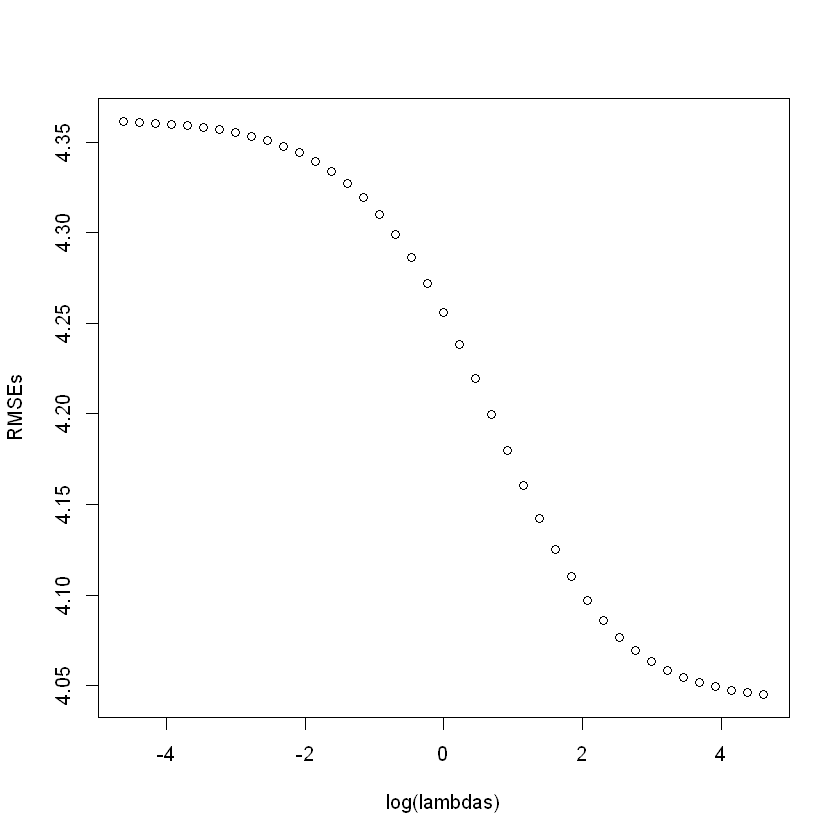

In [12]:
plot(log(lambdas), RMSEs)
best_lam = lambdas[which.min(RMSEs)]
best_lam

In [13]:
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]

ridge_reg = glmnet(as.matrix(train_x), train_y[,1], alpha = 0, family = 'gaussian', lambda = best_lam)

In [14]:
coef(ridge_reg)

33 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)               2.178640e-01
Annual.Hash.Growth        1.405761e-01
Block.Height              6.716946e+01
Block.Interval           -2.716084e-02
Block.Size                6.710354e-03
Daily.Transactions       -9.901459e-05
Difficulty               -1.600023e-02
Fee.Percentage           -1.089547e-02
Fee.Rate                 -2.574166e-02
Two.Week.Hash.Growth     -2.324556e-04
Hash.Rate                 4.120044e-01
Inflation.Rate           -2.006539e+00
Price.Volatility         -4.474588e-03
Bitcoin.Core..BTC..Price  5.379676e-01
Quarterly.Hash.Growth    -1.041958e-03
Total.Transactions        6.697060e+00
Transaction.Size          8.402754e-03
Avg..UTXO.Amount         -8.853459e-02
Velocity...Daily          3.903975e-03
Velocity...Quarterly     -4.122772e-03
Velocity.of.Money         8.986228e-01
DIA.US.Index              6.379210e-01
CNYUSD.Curncy            -2.555489e+00
EURUSD.Curncy         

# Lasso Regression

In [15]:
lambdas <- 10^seq(2, -2, by = -.1)
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]
RMSEs = c()
for (lam in lambdas) {
    lasso_reg = glmnet(as.matrix(train_x), train_y[,1], alpha = 1, family = 'gaussian', lambda = lam)
    pred = predict(lasso_reg, as.matrix(test_x))
    RMSEs = c(RMSEs, rmse(test_y[,1], pred))
}

[1] 0.3981072

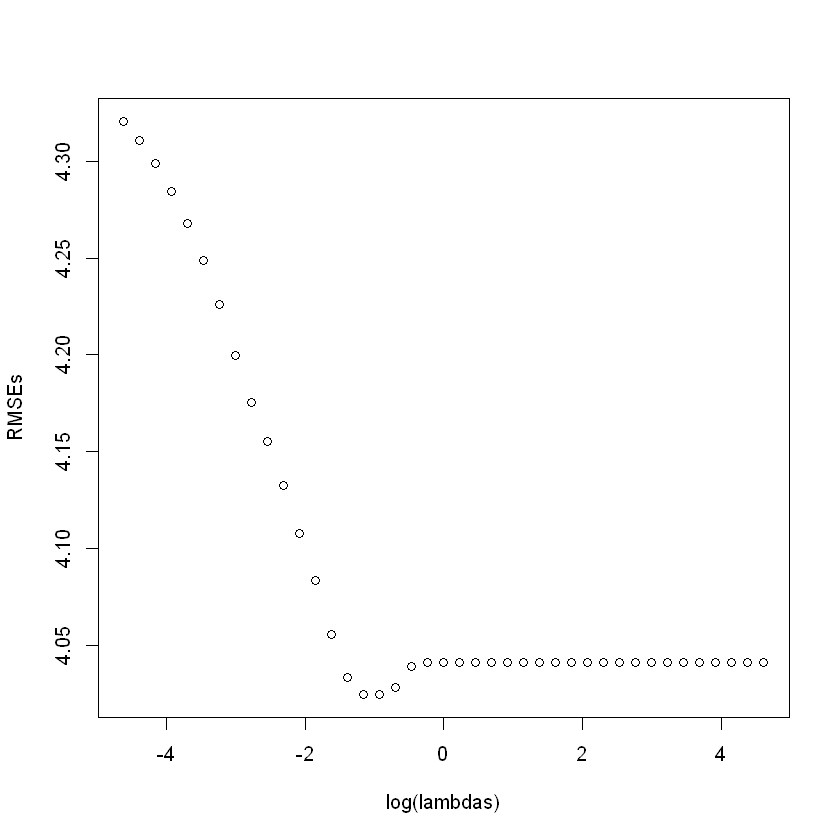

In [16]:
plot(log(lambdas), RMSEs)
best_lam = lambdas[which.min(RMSEs)]
best_lam

In [17]:
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]

lasso_reg = glmnet(as.matrix(train_x), train_y[,1], alpha = 1, family = 'gaussian', lambda = best_lam)

In [18]:
coef(lasso_reg)

33 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)              0.2396606
Annual.Hash.Growth       .        
Block.Height             .        
Block.Interval           .        
Block.Size               .        
Daily.Transactions       .        
Difficulty               .        
Fee.Percentage           .        
Fee.Rate                 .        
Two.Week.Hash.Growth     .        
Hash.Rate                .        
Inflation.Rate           .        
Price.Volatility         .        
Bitcoin.Core..BTC..Price 4.6655755
Quarterly.Hash.Growth    .        
Total.Transactions       .        
Transaction.Size         .        
Avg..UTXO.Amount         .        
Velocity...Daily         .        
Velocity...Quarterly     .        
Velocity.of.Money        .        
DIA.US.Index             .        
CNYUSD.Curncy            .        
EURUSD.Curncy            .        
GDX.US.Equity            .        
SHCOMP.Index             .        
TWSE.Index   

# Elastic net regression

In [19]:
lambdas <- 10^seq(-2, 2, by = .1)
alphas = seq(0, 1, by= .1)
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]

In [20]:
grid = matrix(10000, nrow=21, ncol=11)

In [21]:
min_RMSE = 10000
best_lam = -1
best_alpha = -1
for (i in 1:21) {
    for (j in 1:11) {
        reg = glmnet(as.matrix(train_x), train_y[,1], alpha = alphas[j], family = 'gaussian', lambda = lambdas[i])
        pred = predict(reg, as.matrix(test_x))
        grid[i,j] = rmse(test_y[,1], pred)
        if (grid[i,j] < min_RMSE) {
            best_lam = lambdas[i]
            best_alpha = alphas[j]
            min_RMSE = grid[i,j]
        }
    }
}

In [22]:
best_lam
best_alpha

[1] 0.7943282

[1] 0.4

In [23]:
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]

reg = glmnet(as.matrix(train_x), train_y[,1], alpha = best_alpha, family = 'gaussian', lambda = best_lam)

In [24]:
coef(reg)

33 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)              0.2359316
Annual.Hash.Growth       .        
Block.Height             .        
Block.Interval           .        
Block.Size               .        
Daily.Transactions       .        
Difficulty               .        
Fee.Percentage           .        
Fee.Rate                 .        
Two.Week.Hash.Growth     .        
Hash.Rate                .        
Inflation.Rate           .        
Price.Volatility         .        
Bitcoin.Core..BTC..Price 6.1606285
Quarterly.Hash.Growth    .        
Total.Transactions       .        
Transaction.Size         .        
Avg..UTXO.Amount         .        
Velocity...Daily         .        
Velocity...Quarterly     .        
Velocity.of.Money        .        
DIA.US.Index             .        
CNYUSD.Curncy            .        
EURUSD.Curncy            .        
GDX.US.Equity            .        
SHCOMP.Index             .        
TWSE.Index   

# Random Forest

In [25]:
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]

In [26]:
n_trees = seq(20, 400, by=20)
RMSEs = c()

for (i in n_trees){
    rf <- randomForest(label~., data=train_ds, proximity=TRUE, ntree=i)
    pred = predict(rf, as.matrix(test_x))
    RMSEs = c(RMSEs, rmse(pred, test_y[,1]))
} 


[1] 220

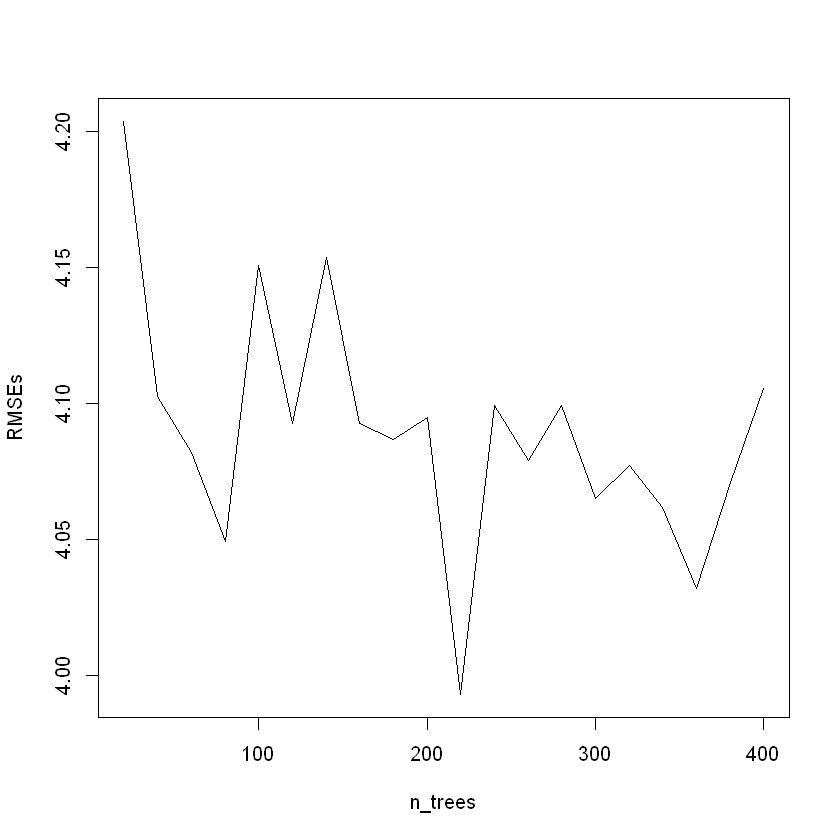

In [27]:
plot(n_trees, RMSEs, type='l')
best_ntree = n_trees[which.min(RMSEs)]
best_ntree

In [28]:
rf <- randomForest(label~., data=train_ds, proximity=TRUE, ntree=best_ntree)
importance(rf)

,IncNodePurity
Annual.Hash.Growth,247.40757
Block.Height,257.80754
Block.Interval,208.04137
Block.Size,202.64323
Daily.Transactions,191.29591
Difficulty,203.26577
Fee.Percentage,345.40716
Fee.Rate,407.33217
Two.Week.Hash.Growth,370.22973
Hash.Rate,359.23799


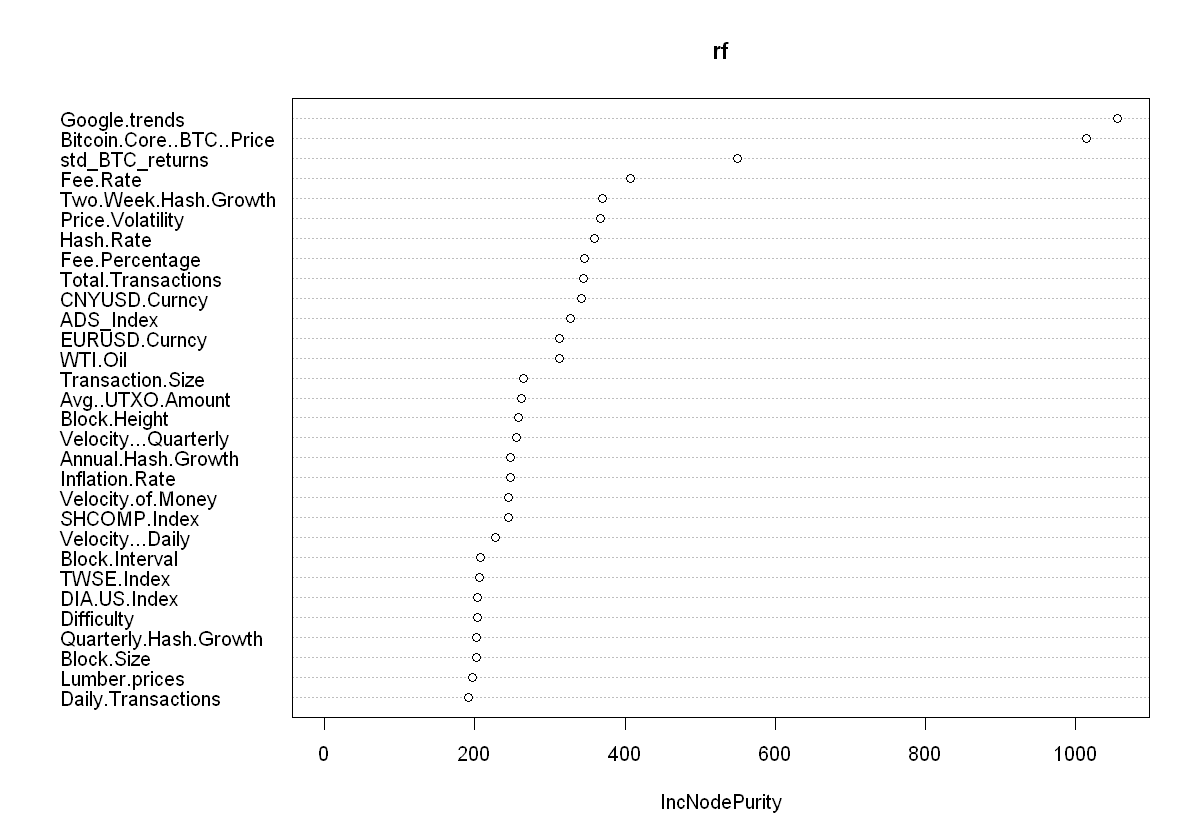

In [29]:
options(repr.plot.width=10)
varImpPlot(rf,type=2)

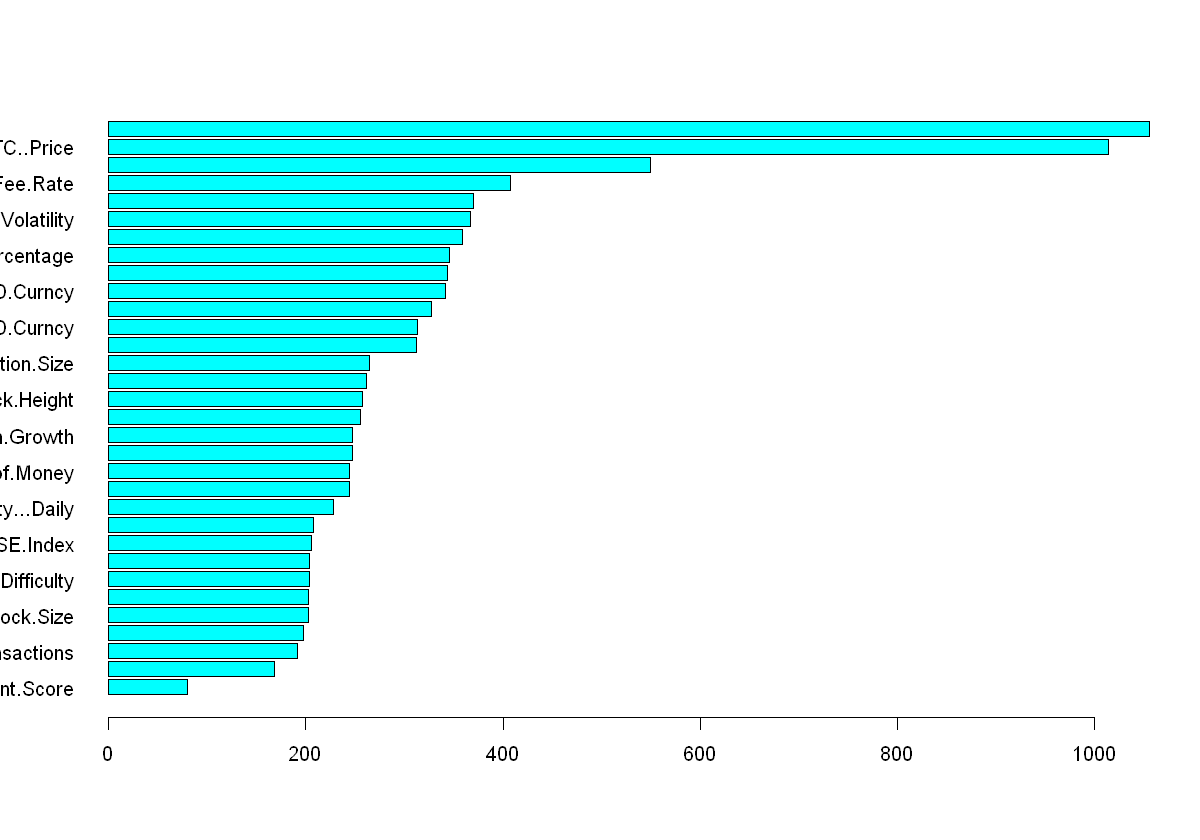

In [30]:
options(repr.plot.width=10)
par(mat=c(5,6,4,1)+.1)
barplot(sort(importance(rf)[,1], decreasing = FALSE), horiz=TRUE, las=1, col='cyan')

In [31]:
sort(importance(rf)[,1], decreasing = TRUE)

Google.trends Bitcoin.Core..BTC..Price          std_BTC_returns 
              1055.80787               1013.83870                549.78398 
                Fee.Rate     Two.Week.Hash.Growth         Price.Volatility 
               407.33217                370.22973                367.34806 
               Hash.Rate           Fee.Percentage       Total.Transactions 
               359.23799                345.40716                343.89809 
           CNYUSD.Curncy                ADS_Index            EURUSD.Curncy 
               341.37884                327.45791                312.92946 
                 WTI.Oil         Transaction.Size         Avg..UTXO.Amount 
               312.35680                264.75987                261.79381 
            Block.Height     Velocity...Quarterly       Annual.Hash.Growth 
               257.80754                255.49498                247.40757 
          Inflation.Rate        Velocity.of.Money             SHCOMP.Index 
               246.77393                244.59777                244.41341 
        Velocity...Daily           Block.Interval               TWSE.Index 
               227.69947                208.04137                205.53661 
            DIA.US.Index               Difficulty    Quarterly.Hash.Growth 
               204.05928                203.26577                202.75210 
              Block.Size            Lumber.prices       Daily.Transactions 
               202.64323                197.32304                191.29591 
           GDX.US.Equity          Sentiment.Score 
               168.31208                 80.10241

# Boosting

In [32]:
# install.packages("xgboost")

In [33]:
library(xgboost)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [34]:
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]

In [35]:
depths = seq(1, 10, by=1)

In [36]:

RMSEs = c()

for (i in depths) {
    xgb <- xgboost(data = as.matrix(train_x), label = train_y[,1], max.depth = i, eta = 1, nthread = 2, nrounds = 2, objective = "reg:linear")
    pred = predict(xgb, as.matrix(test_x))
    RMSEs = c(RMSEs, rmse(pred, test_y[,1]))
}


[21:33:34] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3.145121 
[2]	train-rmse:3.115690 
[21:33:34] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3.051309 
[2]	train-rmse:2.987429 
[21:33:34] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:2.930422 
[2]	train-rmse:2.818468 
[21:33:34] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:2.774472 
[2]	train-rmse:2.649380 
[21:33:35] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:2.597043 
[2]	train-rmse:2.374289 
[21:33:35] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now

[1] 2

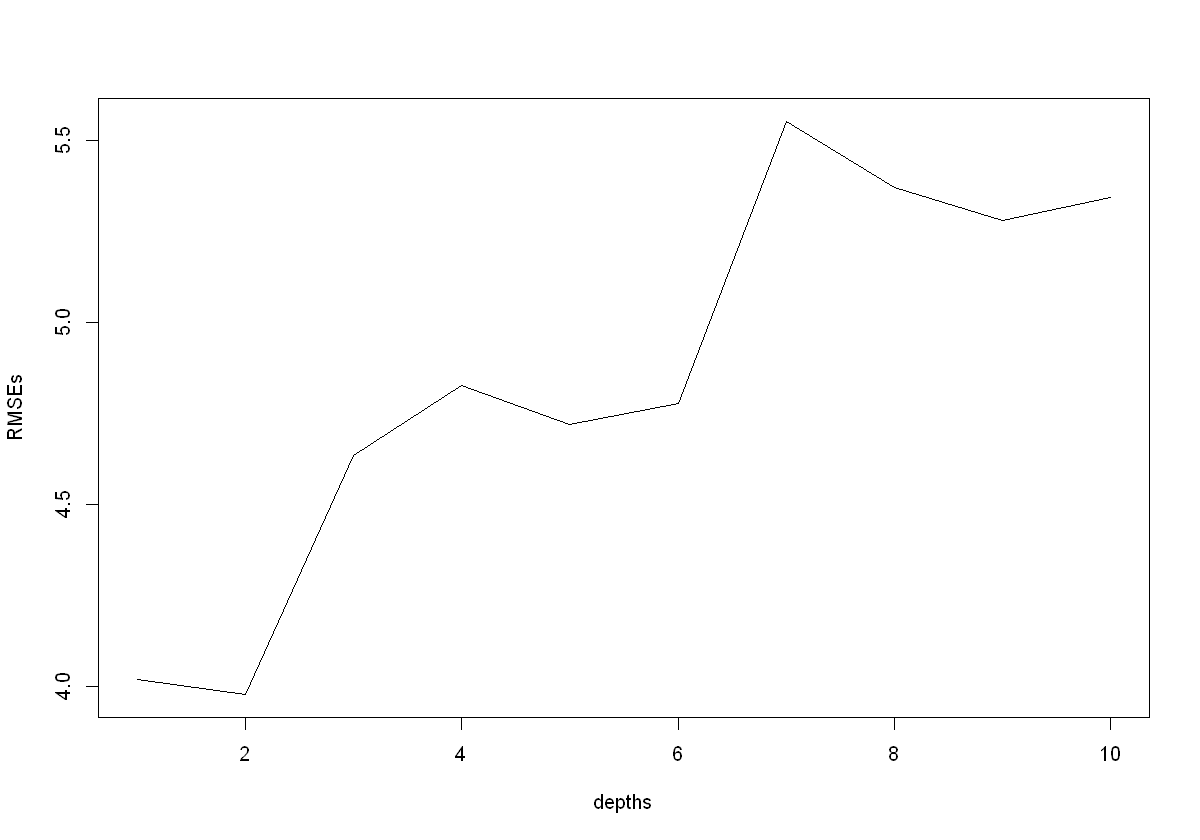

In [37]:
plot(depths, RMSEs, type='l')
best_depth = depths[which.min(RMSEs)]
best_depth

In [38]:
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]

xgb <- xgboost(data = as.matrix(train_x), label = train_y[,1], max.depth = best_depth, eta = 1, nthread = 2, nrounds = 2, objective = "reg:linear")

[21:33:35] WARNING: amalgamation/../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:3.290546 
[2]	train-rmse:3.219818 


In [39]:
xgb.importance(model=xgb)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Bitcoin.Core..BTC..Price,0.4843882,0.71088795,0.5000000
Google.trends,0.4076194,0.03911205,0.3333333
Hash.Rate,0.1079924,0.25000000,0.1666667


# Compare all models

In [82]:
train_size = floor(0.75 * nrow(df))
train_data = df[1:train_size, ]
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]
test_data = df[train_size:nrow(df), ]
test_x = test_data[-ncol(test_data)+1]
test_y = test_data[ncol(test_data)-1]

In [83]:
price_true = df_all$price[train_size:nrow(df_all)]

In [84]:
pred = predict(lmbtc, train_x)
rmse(pred, train_y[,1])

[1] 3.325195

[1] 4.068989

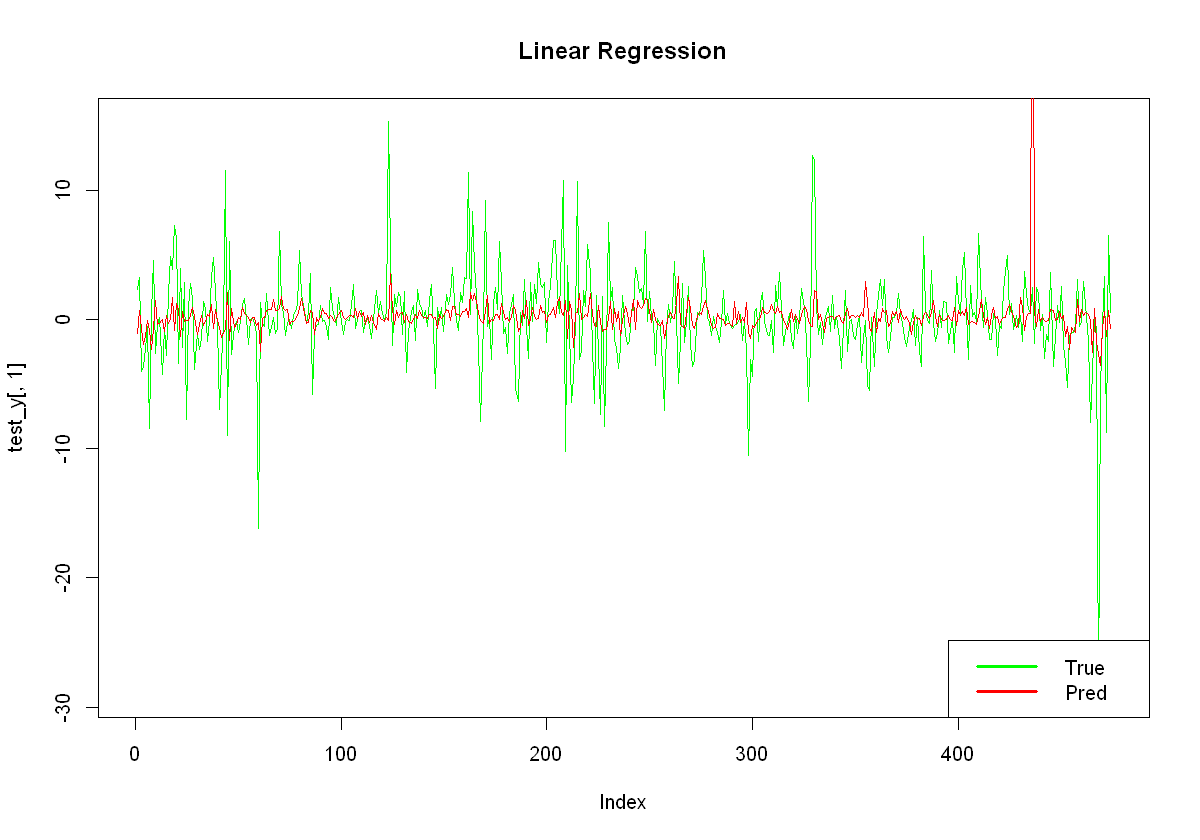

In [85]:
pred = predict(lmbtc, test_x)
plot(test_y[,1], type='l', col='green', main="Linear Regression")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 348.0918

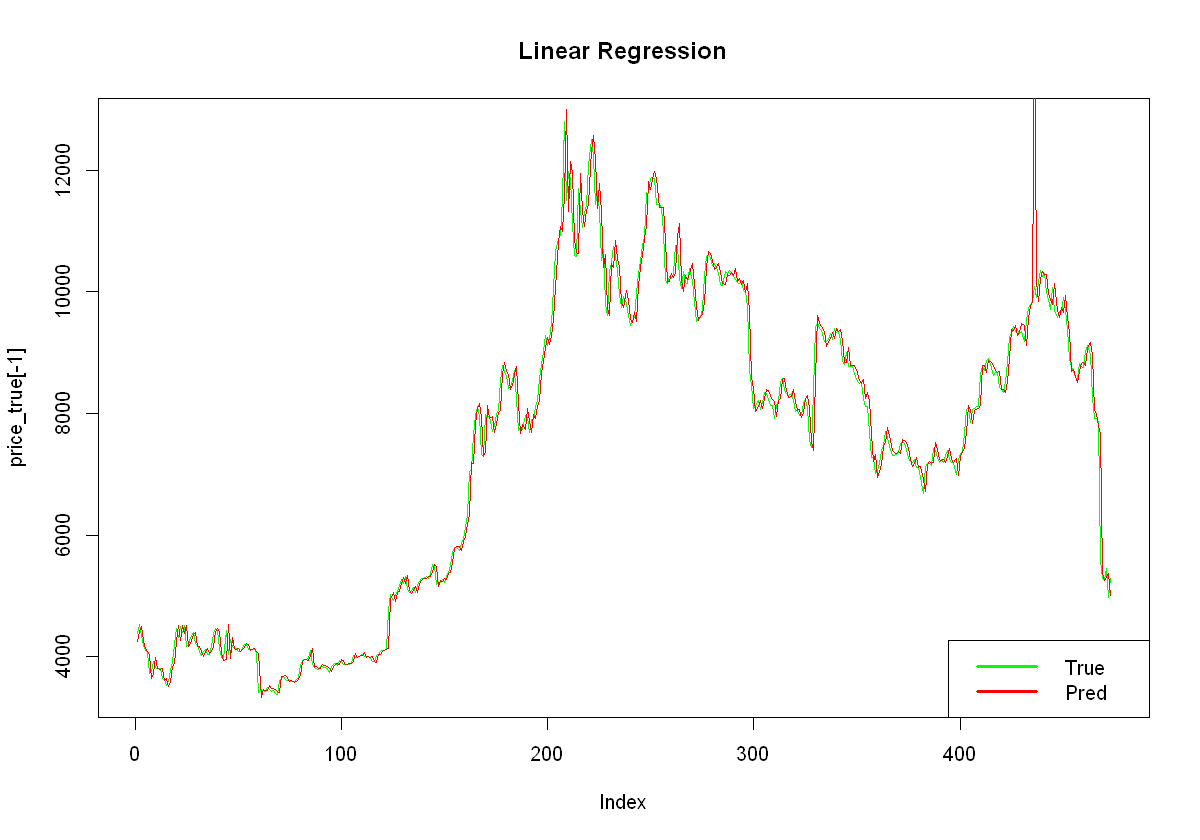

In [43]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="Linear Regression")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

In [88]:
pred = predict(lasso_reg, as.matrix(train_x))
rmse(pred, train_y[,1])

[1] 3.390471

[1] 3.462989

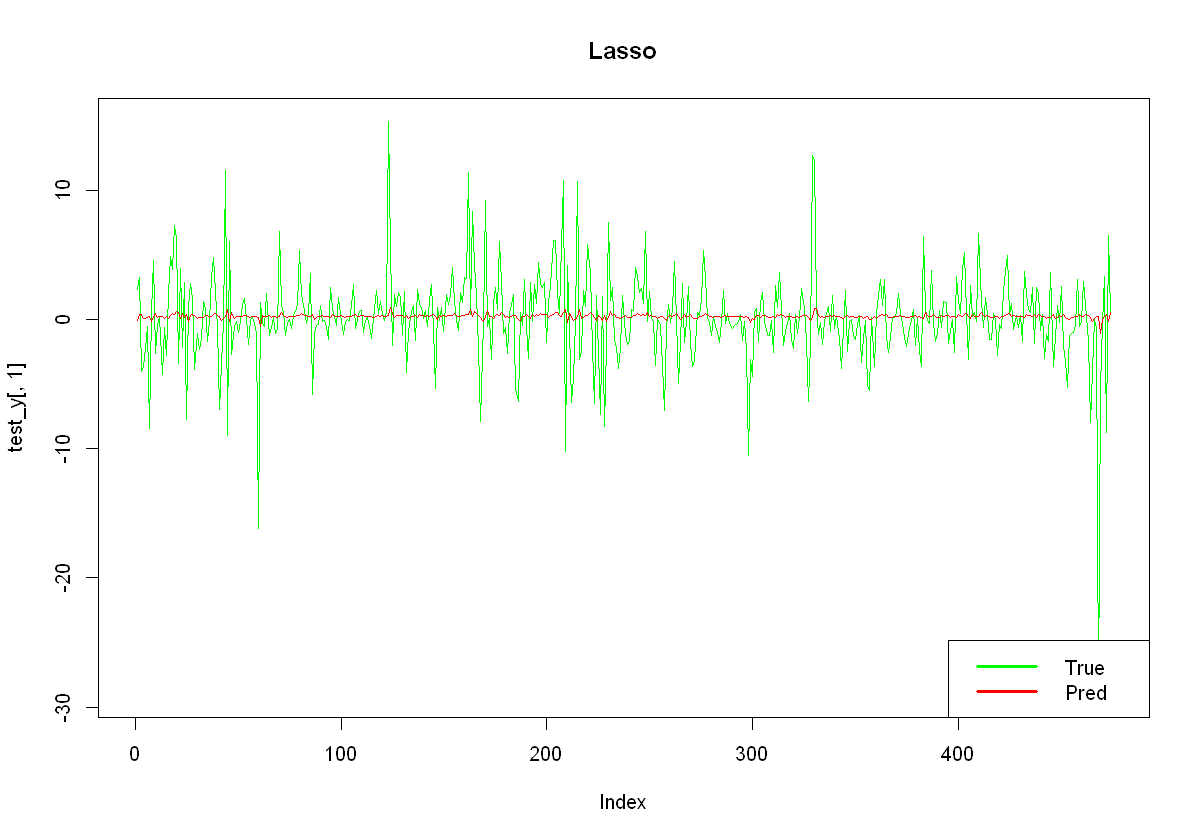

In [89]:
pred = predict(lasso_reg, as.matrix(test_x))
plot(test_y[,1], type='l', col='green', main="Lasso")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 274.0373

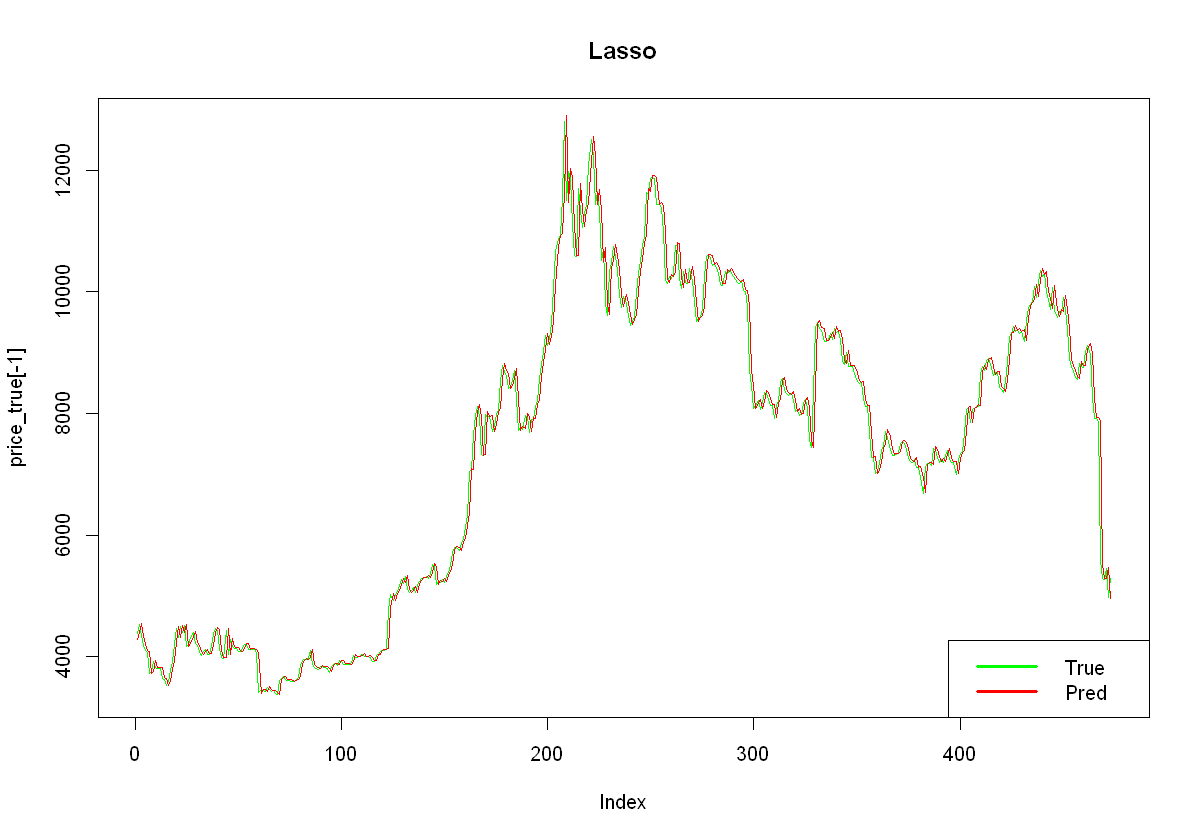

In [45]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="Lasso")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

In [90]:
pred = predict(ridge_reg, as.matrix(train_x))
rmse(pred, train_y[,1])

[1] 3.406757

[1] 3.472311

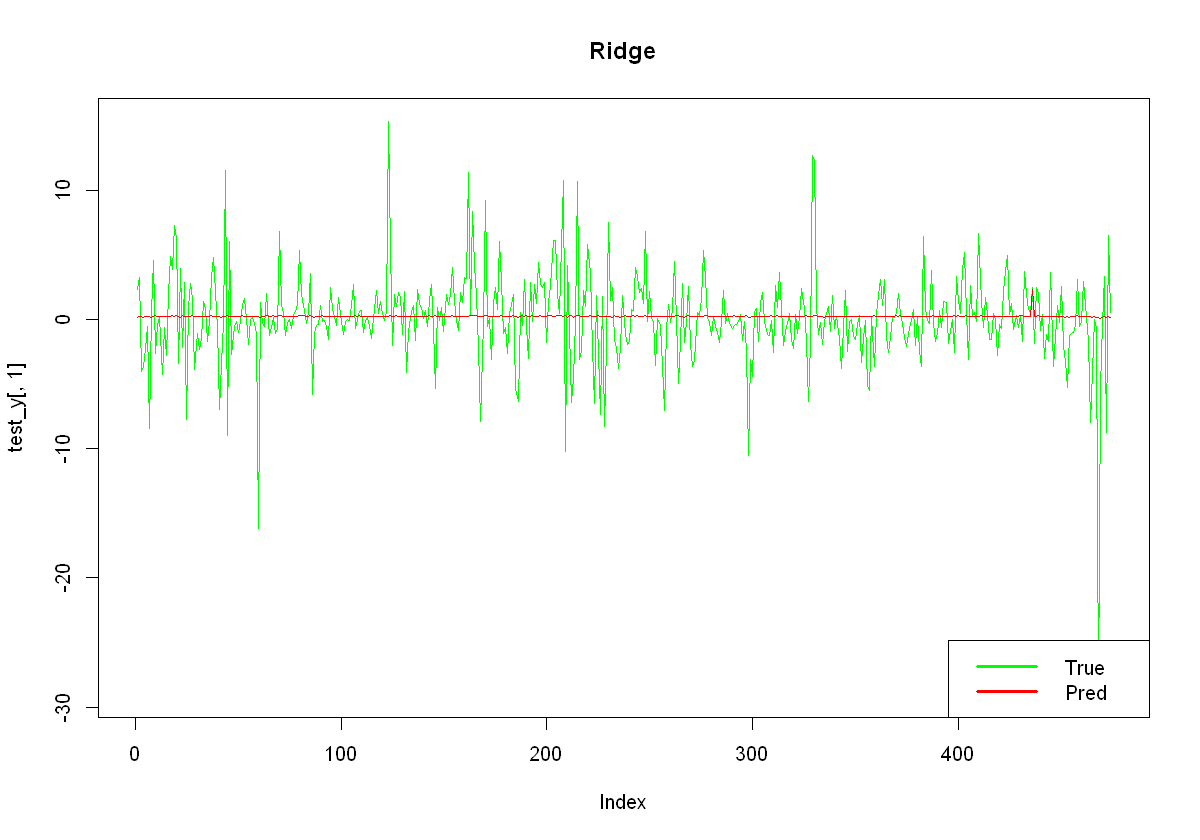

In [91]:
pred = predict(ridge_reg, as.matrix(test_x))
plot(test_y[,1], type='l', col='green', main="Ridge")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 274.753

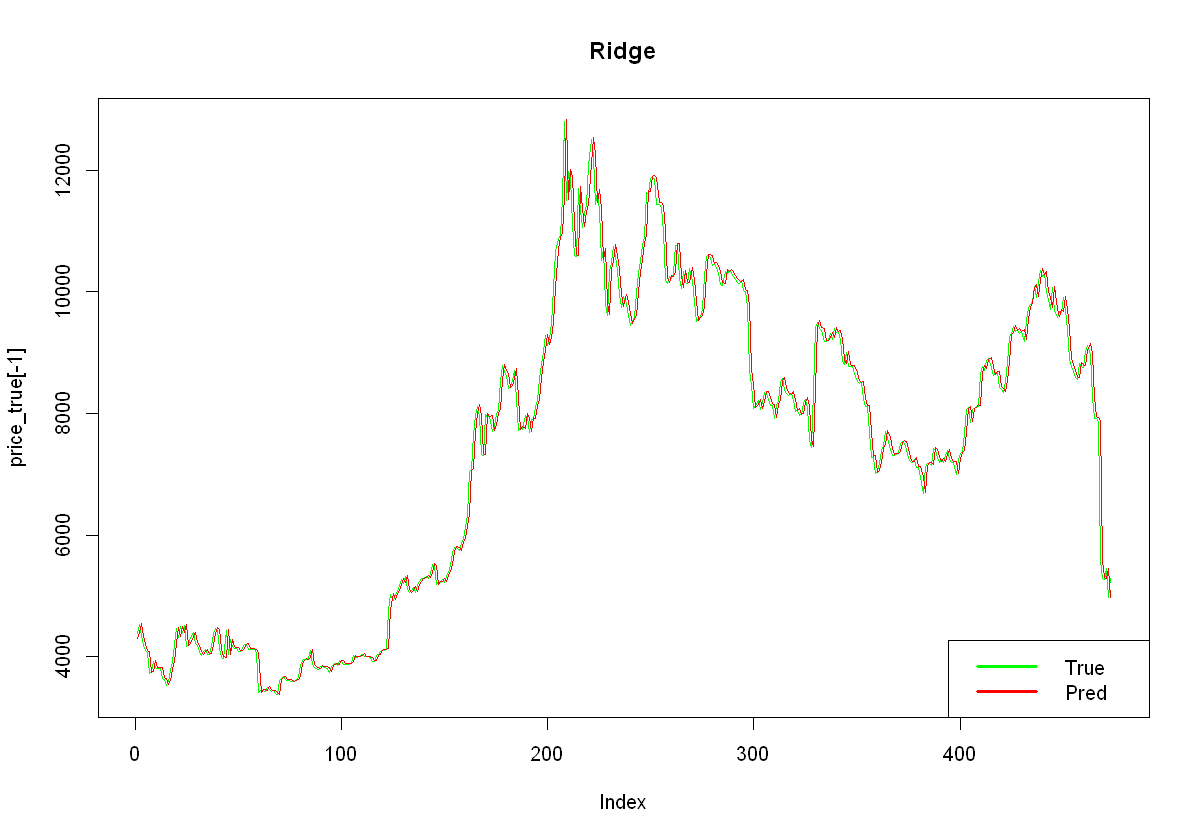

In [47]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="Ridge")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

In [92]:
pred = predict(reg, as.matrix(train_x))
rmse(pred, train_y[,1])

[1] 3.384859

[1] 3.458733

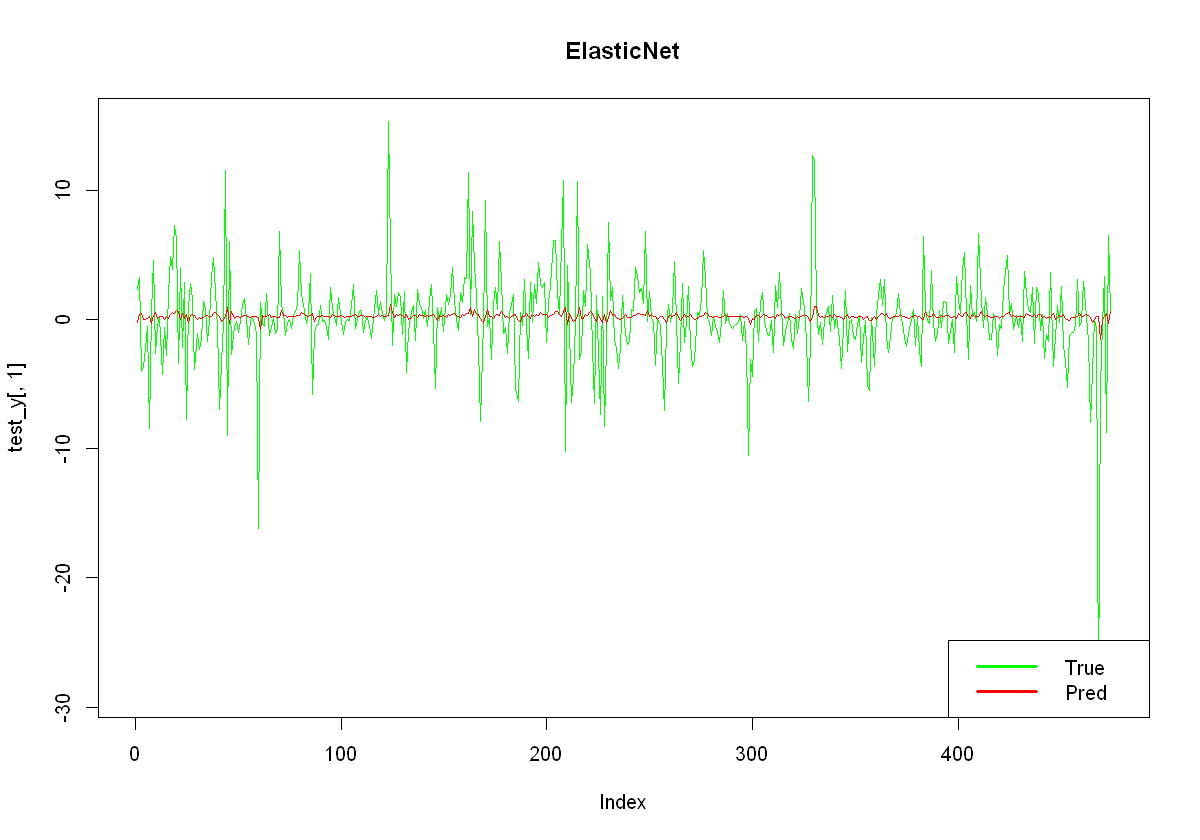

In [93]:
pred = predict(reg, as.matrix(test_x))
plot(test_y[,1], type='l', col='green', main="ElasticNet")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 273.6574

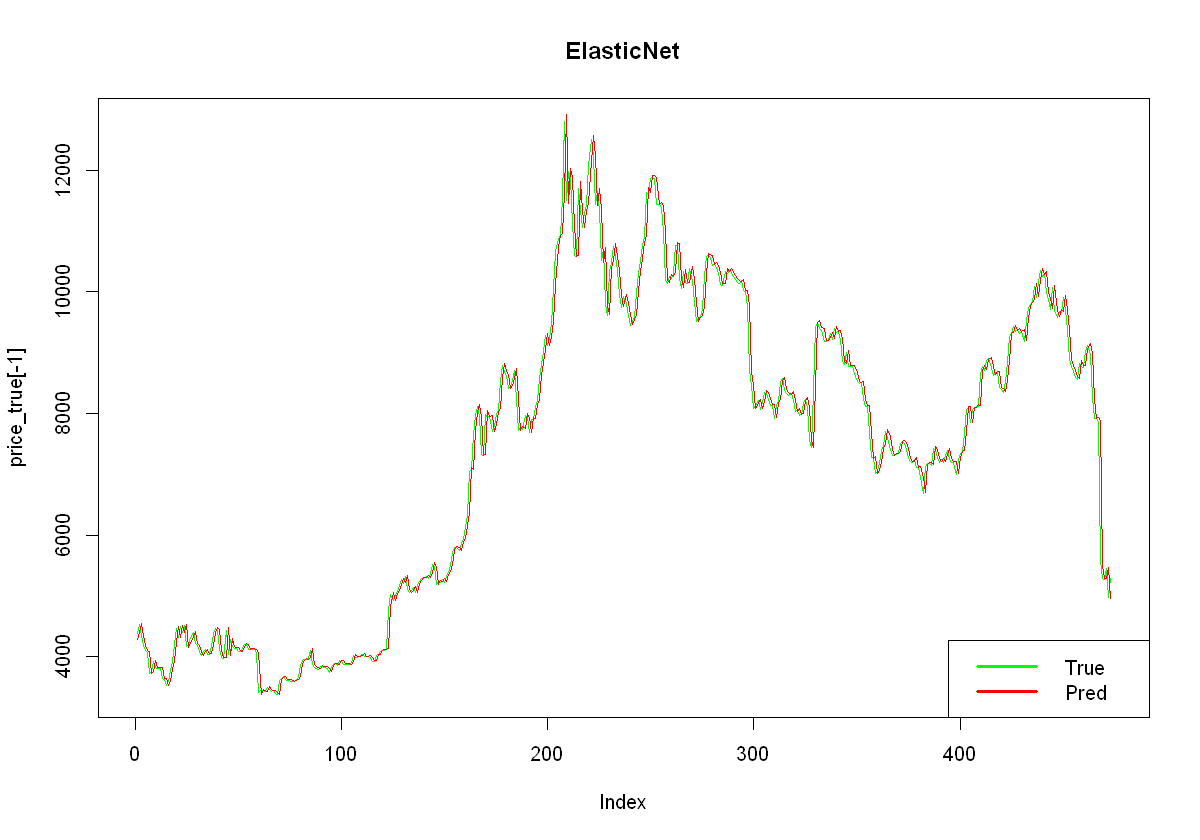

In [49]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="ElasticNet")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

In [94]:
pred = predict(rf, as.matrix(train_x))
rmse(pred, train_y[,1])

[1] 2.335989

[1] 3.465765

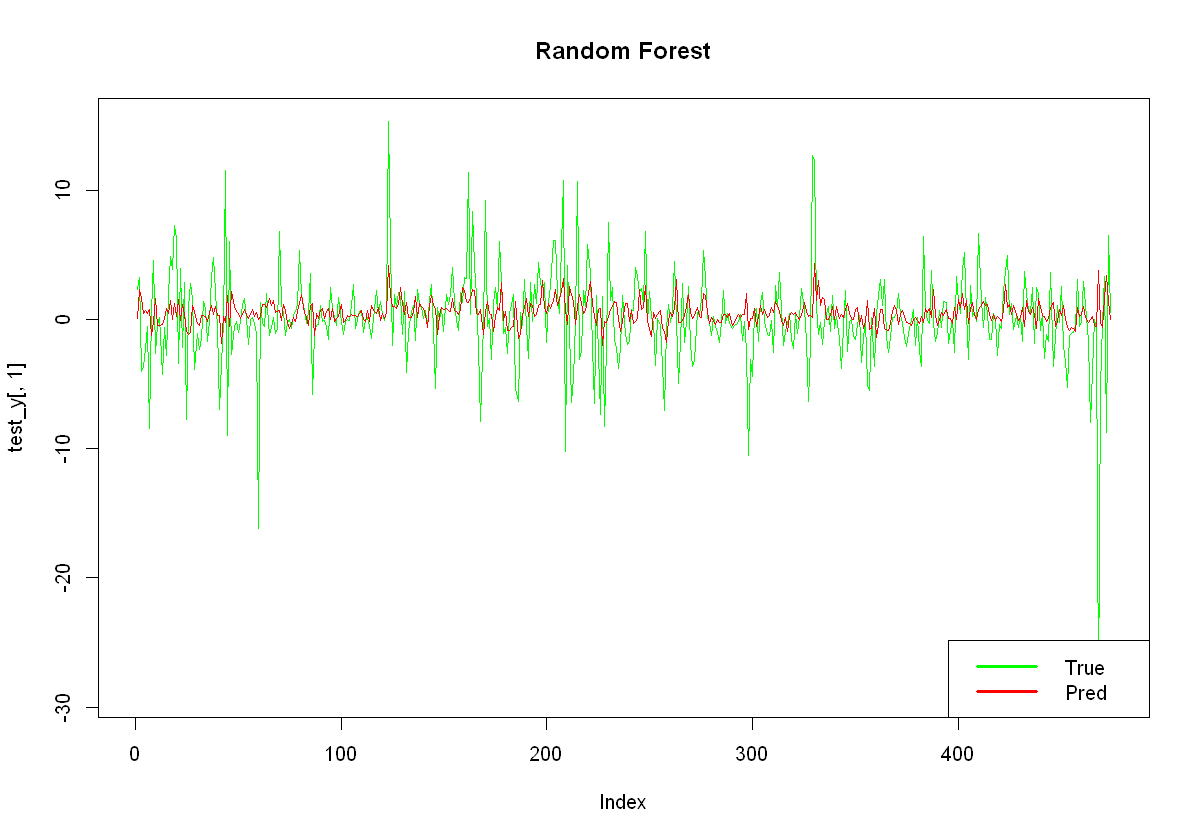

In [95]:
pred = predict(rf, as.matrix(test_x))
plot(test_y[,1], type='l', col='green', main="Random Forest")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 273.296

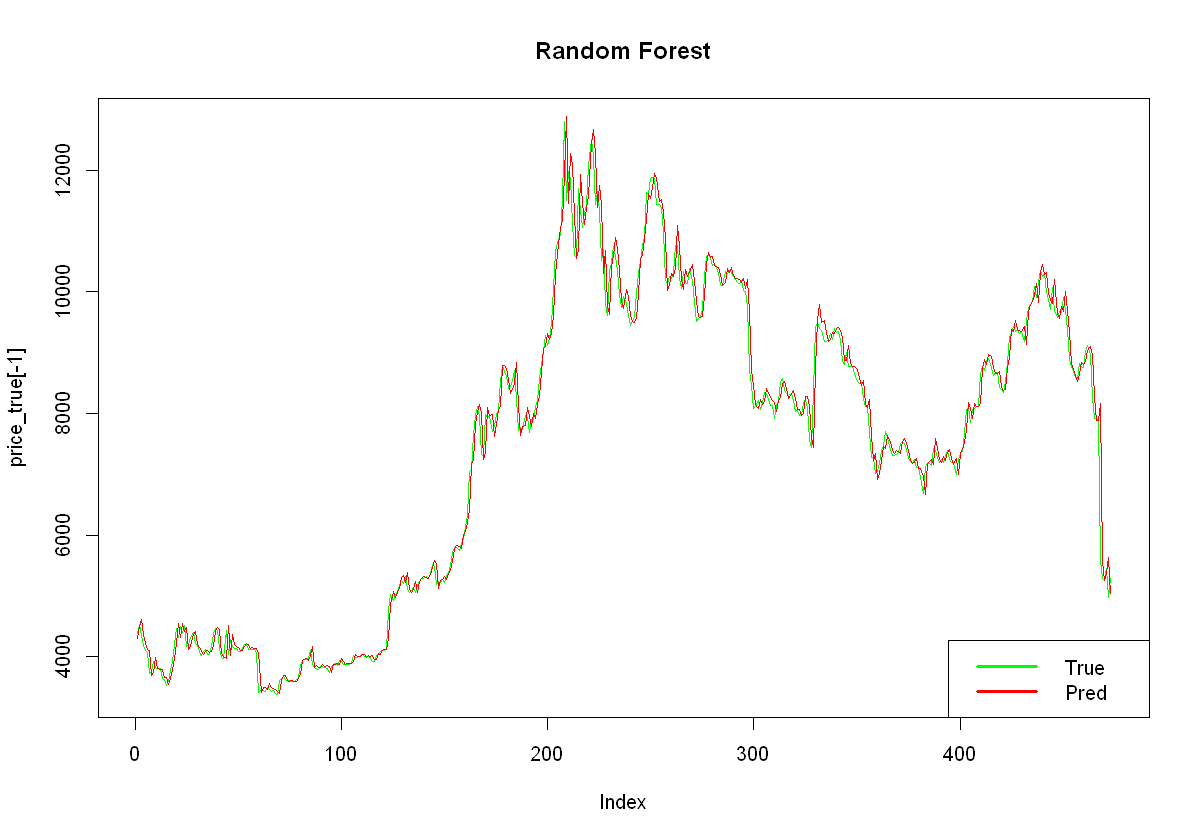

In [51]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="Random Forest")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

In [96]:
pred = predict(xgb, as.matrix(train_x))
rmse(pred, train_y[,1])

[1] 3.219818

[1] 3.464612

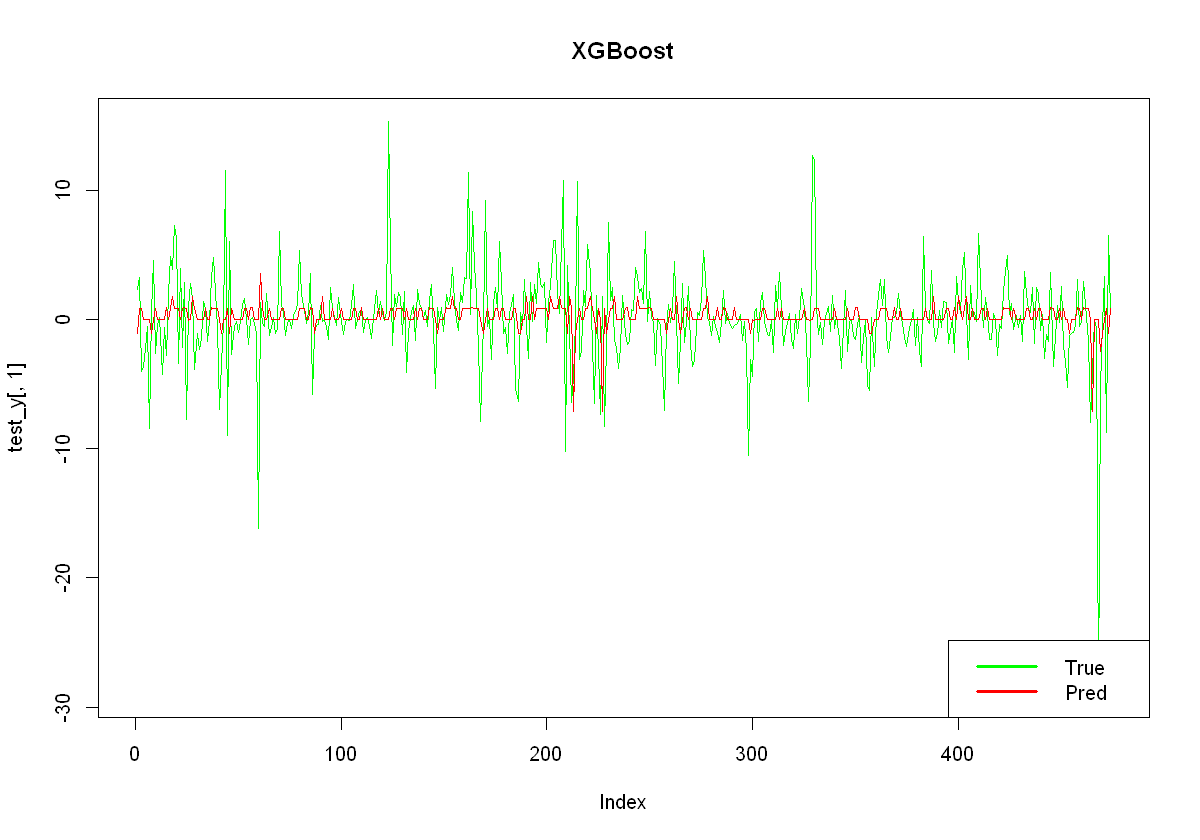

In [52]:
pred = predict(xgb, as.matrix(test_x))
plot(test_y[,1], type='l', col='green', main="XGBoost")
lines(pred, type="l", col="red")
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))
rmse(pred, test_y[,1])

[1] 275.134

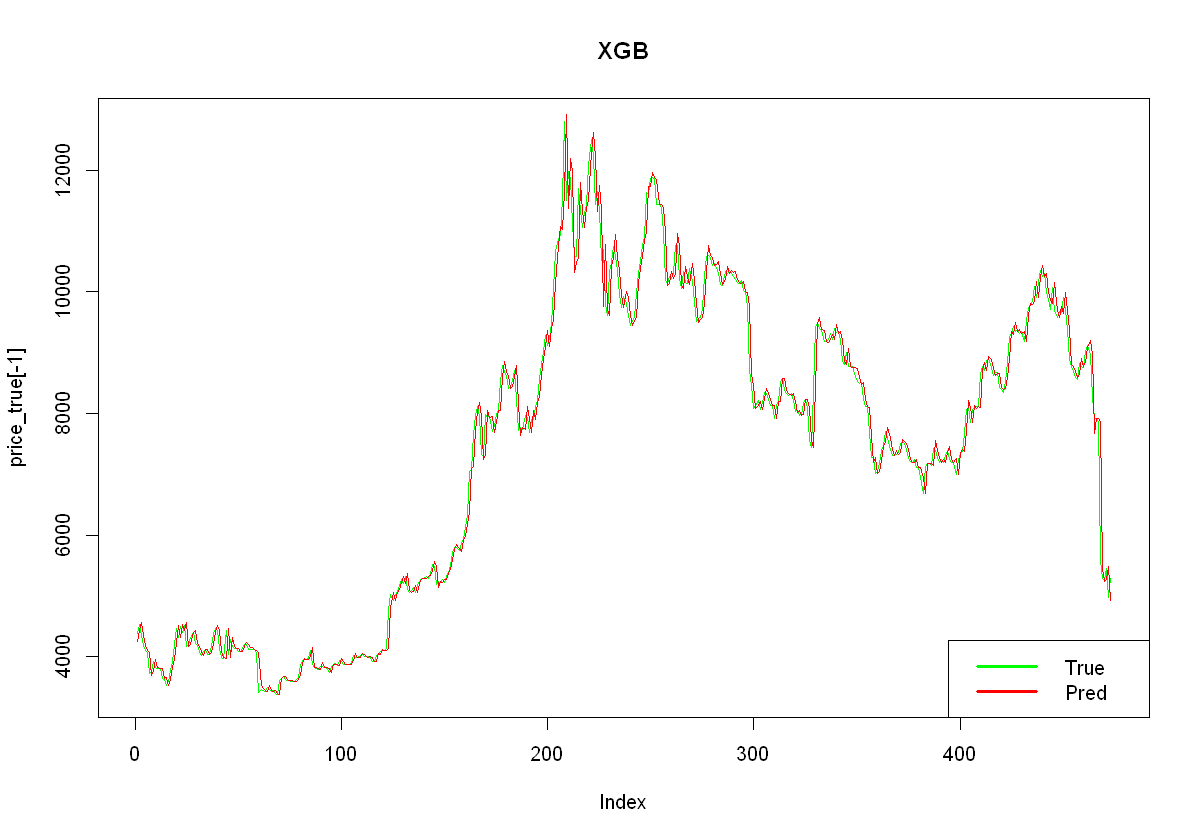

In [53]:
pred_price = price_true*(100+pred)/100
plot(price_true[-1], type='l', col='green', main="XGB")
lines(pred_price[-length(pred_price)], type="l", col="red")
rmse(price_true[-1],pred_price[-length(pred_price)])
legend("bottomright", legend = c("True", "Pred"), lwd = 3, col = c("green", "red"))

# Classification

In [97]:
cls_df = df
cls_df$label = as.factor(sign(cls_df$label))
cls_df$Bitcoin.Core..BTC..Price = as.factor(sign(cls_df$Bitcoin.Core..BTC..Price))

In [98]:
train_size = floor(0.75 * nrow(cls_df))
train_data = cls_df[1:train_size, ]
test_data = cls_df[train_size:nrow(cls_df), ]

In [99]:
train_size = floor(0.75 * nrow(train_data))
train_ds = train_data[1:train_size, ]
val_ds = train_data[train_size:nrow(train_data), ]

# Logistic regression

In [100]:
log_reg = glm(label ~., family=binomial(link='logit'), data=train_data)

In [101]:
summary(log_reg)


Call:
glm(formula = label ~ ., family = binomial(link = "logit"), data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8129  -1.2209   0.8823   1.0779   1.5594  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)   
(Intercept)                1.612e-01  4.588e-01   0.351  0.72535   
Annual.Hash.Growth         2.582e+00  2.154e+00   1.199  0.23068   
Block.Height              -7.824e+02  1.719e+03  -0.455  0.64901   
Block.Interval             1.427e+00  8.259e-01   1.727  0.08413 . 
Block.Size                -1.070e+00  7.219e-01  -1.482  0.13841   
Daily.Transactions         7.125e-01  7.402e-01   0.963  0.33571   
Difficulty                -3.303e-02  9.428e-01  -0.035  0.97205   
Fee.Percentage             2.381e-01  2.305e-01   1.033  0.30163   
Fee.Rate                  -6.133e-01  3.163e-01  -1.939  0.05248 . 
Two.Week.Hash.Growth       5.274e-04  5.702e-03   0.092  0.92631   
Hash.Rate                  2.957e+00 

# SVM

In [102]:
library(e1071)

In [103]:
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]

In [104]:
costs = seq(1,21, by=3)
miss = c()

for (i in costs) {
    svmfit = svm(label ~ ., data = train_data, kernel = "linear", cost = i, scale = FALSE)
    pred = predict(svmfit, train_x)
    miss = c(miss, mean(pred != test_y[,1]))
}


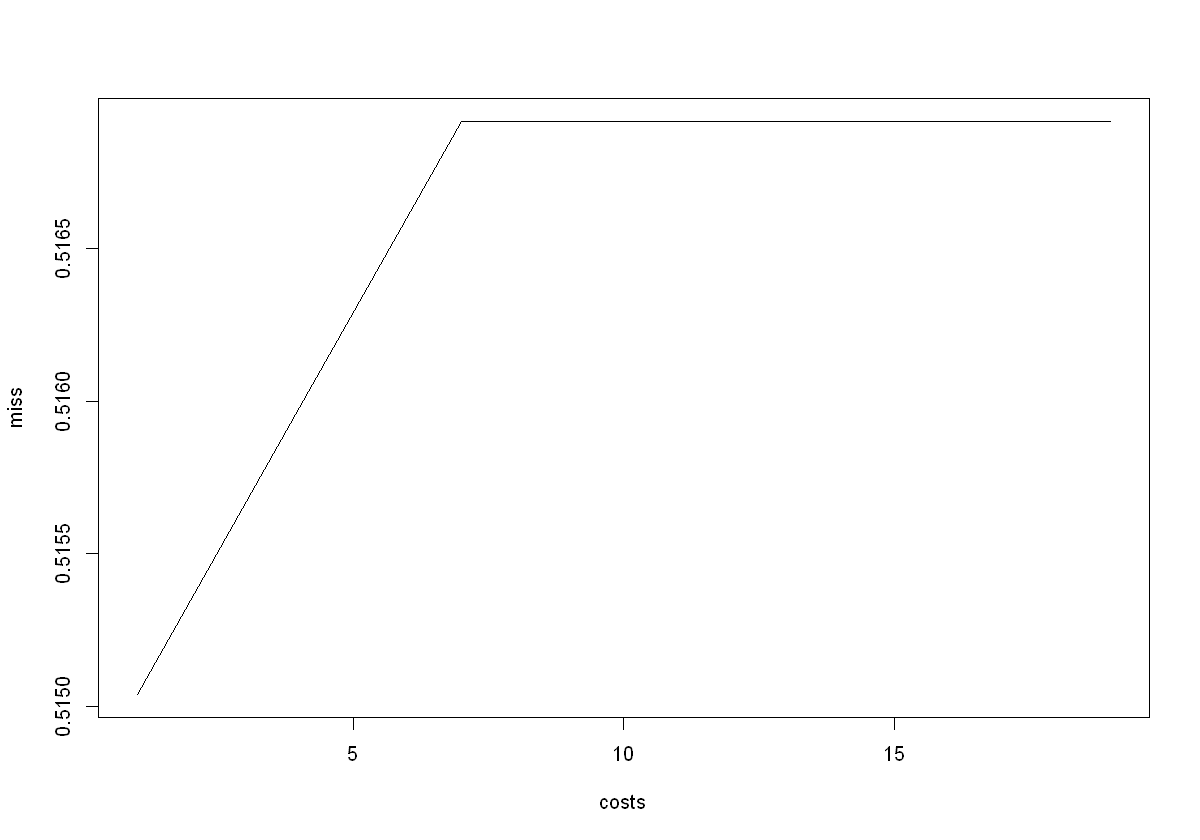

In [105]:
plot(costs, miss, type='l')
best_cost = costs[which.min(miss)]

In [106]:
train_x = train_data[-ncol(train_data)+1]
train_y = train_data[ncol(train_data)-1]

svmfit = svm(label ~ ., data = train_data, kernel = "linear", cost = best_cost, scale = FALSE)

# KNN

In [107]:
library(class)

In [108]:
train_x = train_ds[-ncol(train_ds)+1]
train_y = train_ds[ncol(train_ds)-1]
test_x = val_ds[-ncol(val_ds)+1]
test_y = val_ds[ncol(val_ds)-1]

In [109]:
ks = seq(5, 100, by=3)
miss = c()
for (i in ks) {
    knn.pred = knn(train_ds, val_ds, train_y[,1], k=i)
    miss = c(miss, mean(knn.pred != test_y[,1]))
}
    

[1] 47

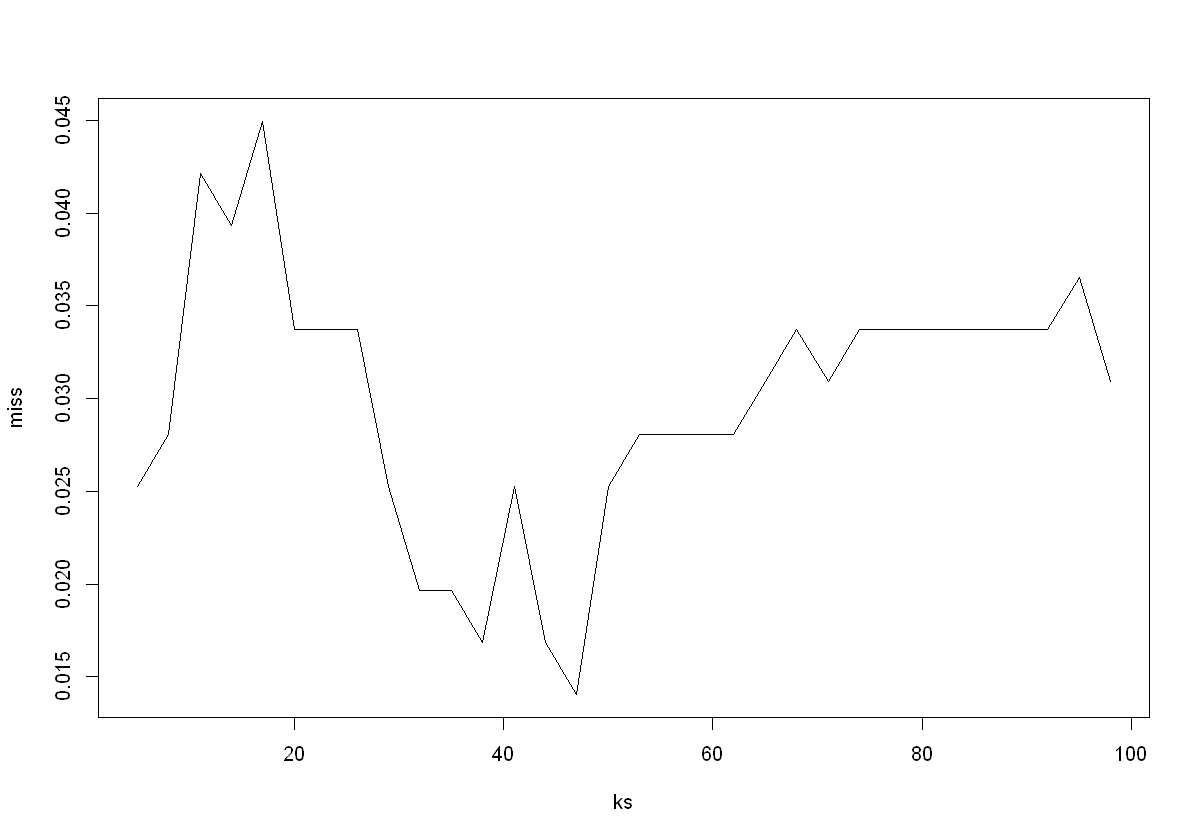

In [110]:
plot(ks, miss, type='l')
best_k = ks[which.min(miss)]
best_k

# XGBoost Cls

In [111]:
# train_x = train_ds[-ncol(train_ds)+1]
# train_y = train_ds[ncol(train_ds)-1]
# test_x = val_ds[-ncol(val_ds)+1]
# test_y = val_ds[ncol(val_ds)-1]

In [112]:
# depths = seq(1, 10, by=1)
# RMSEs = c()

# for (i in depths) {
#     dtrain <- xgb.DMatrix(data = as.matrix(train_x), label = train_y[,1])
#     xgb <- xgboost(dtrain, max.depth = i, eta = 1, nthread = 2, nrounds = 2, objective = "binary:logistic")
#     pred = predict(xgb, as.matrix(test_x))
#     RMSEs = c(RMSEs, rmse(pred, test_y[,1]))
# }

In [113]:
# ?xgboost

# Compare

In [114]:
test_x = test_data[-ncol(test_data)+1]
test_y = test_data[ncol(test_data)-1]

In [115]:
prob = predict(log_reg, test_x, type='response')
threshold = 0.3

In [120]:
prob1 = predict(log_reg, train_x, type='response')
y_hat = ifelse(prob > threshold, 1, 0)
error = mean(y_hat != train_y)
acc = 1 - error

# paste(tp, fn)
# print results
paste('Accuracy: ', acc)

[1] "Accuracy:  0.569548872180451"

In [116]:
y_hat = ifelse(prob > threshold, 1, 0)

In [117]:
tp = sum(y_hat == test_y & y_hat == 1)
tn = sum(y_hat == test_y & y_hat == 0)
fp = sum(y_hat != test_y & y_hat == 1)
fn = sum(y_hat != test_y & y_hat == 0)

# calculate evaluation metrics
error = mean(y_hat != test_y)
acc = 1 - error

# paste(tp, fn)
# print results
paste('Accuracy: ', acc)
paste('True Positive Rate:', tp/(tp+fn))
paste('True Negative Rate:', tn/(tn+fp))

[1] "Accuracy:  0.493670886075949"

[1] "True Positive Rate: 0.975"

[1] "True Negative Rate: 0"

In [75]:
# svm

In [121]:
pred = predict(svmfit, train_x)
acc = mean(pred == train_y[,1])
acc

[1] 0.5798872

In [ ]:
pred = predict(svmfit, test_x)

In [77]:
acc = mean(pred == test_y[,1])
acc

[1] 0.4978903

In [78]:
# KNN

In [79]:
knn.pred = knn(train_data, test_data, train_data[ncol(train_data)-1][,1], k=best_k)
acc = mean(knn.pred == test_y[,1])
acc

[1] 0.9873418

In [118]:
best_k

[1] 47